In [481]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import requests
from nltk.corpus import stopwords as nltk_stopwords
from string import punctuation
from kneed.knee_locator import KneeLocator
from matplotlib import pyplot as plt
import nltk
import re


# # Endereço da API dos comentários do wikilegis
# BABEL_API_URL = 'https://babel.labhackercd.leg.br/api/v1/manifestations?manifestation_type__id=3'

# # Pegando comentários da API do Babel
# data = requests.get(BABEL_API_URL).json()['results']
# for i in range(2, 11):
#     data += requests.get(BABEL_API_URL + '&page=%s' % i).json()['results']

# comments = [comment['content'] for comment in data]

# Comentários do teste no Google Docs
comments = ['O problema não me parece ser a conotação erótica ou sexual em si mesma, pois ela pode ter conexão com o produto (ex. camisinhas). O problema é se a linguagem promove a violência, a exploração ou discriminação da mulher, como dito mais à frente. Somente assim justificaria alguma penalidade.',
            'Acho que deve ter um prazo mínimo! E se só suspenderem por 1 dia? Quem divulgou precisa realmente ser penalizado pra aprender que fez uma ❤! Acho justo que fiquem sem poder divulgar o produto por um bom tempo!',
            'Concordo muito com essa medida!',
            'Entendi no Inciso II que é pra suspender qualquer outra propaganda do produto, mas aí aqui no VI a propaganda em si que causa a infração é suspendida proporcionalmente ao tempo que foi originalmente transmitida? Porque não é suspendida por completo? Me parece que há margem para dubiedade quando se compara o II com o VI.',
            'Quem seriam essas autoridades?',
            'Senti falta no texto do projeto de referência a mídias sociais... e outros, como impressos, outdoor...',
            'O mais correto não seria suspender a propaganda por completo?',
            'A faixa de valores deve estar submetida a algum índice de reajuste anual para repor a inflação e mantê-lo proporcional.',
            'Esse critério de multa é ruim. Pode ser muito para uns e irrelevante para outros. Talvez um critério atrelado ao valor investido na propaganda seja mais justo.',
            '30 dias é muito tempo, podendo até chegar ao fim da campanha publicitária.',
            'Ta aí o ex.... Quem é o infrator que vai receber a tal advertência? O publicitário? O dono da agência? O dono da empresa/sócios?',
            'Por que só propagandas de produtos de consumo? Propagandas de serviços também podem ser misóginas.',
            'Concordo com o intuito do artigo e gostaria de frisar mais ainda a necessidade de que haja EVIDÊNCIA da exploração, violência ou discriminação contra a mulher. É importante tomar cuidado com a liberdade que o governo tem de proibir ou não determinada manifestação de expressão, pois pode configurar censura! Espero que a lei seja bem clara sem margem para dubiedade a ser explorada por advogados.',
            'Campanhas publicitárias? O que dizer dos video-clips de funk, por exemplo, que têm um apelo muito maior? Vai, malandra, vai!',
            'Agora o governo vai decidir o que pode ou não ser publicado? Censura, burocracia...',
            'Porque só feminina?',
            'Acho importante explicitar o gênero feminino, pois hoje é esse gênero que sofre com esse tipo de propaganda',
            'Deve proibir a discriminação independente do gênero.',
            'Acho o texto muito confuso, mesmo para um projeto de lei... hahahaa Quem é o "infrator", citado tantas vezes? A empresa que contratar? A agência que preparar? O veículo que divulgar? Não fica nada claro isso. O problema, na minha avaliação, começa na primeira frase... "as campanhas publicitárias ficam proibidas de exibir"...??? Na verdade, o sujeito deveria vir claro aí já no início do projeto. Exemplo prático de texto de lei similar: https://gov-rj.jusbrasil.com.br/legislacao/535364538/lei-7835-18-rio-de-janeiro-rj',
            'Muito restrito. Poderia ampliar para além de produtos de consumo.'
           ]


stopwords = nltk_stopwords.words('portuguese') + list(punctuation)

In [449]:
stemmer = nltk.RSLPStemmer()
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stems = [stemmer.stem(t) for t in tokens]
    return list(set(stems))

In [450]:
stopwords = nltk_stopwords.words('portuguese') + list(punctuation)
stem_stopwords = [stemmer.stem(word) for word in stopwords]

In [470]:
vectorizer = TfidfVectorizer(stop_words=stopwords,
#                              tokenizer=tokenize_and_stem,
                             smooth_idf=True,
                             analyzer='word',
                             token_pattern=r'\w{2,}',  #vectorize 3-character words or more
                             ngram_range=(1, 2),
                             max_features=30000)
X = vectorizer.fit_transform(comments)

In [475]:
distortions = []
K = range(2, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit_transform(X)
    distortions.append(sum(np.min(cdist(X.toarray(), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

12


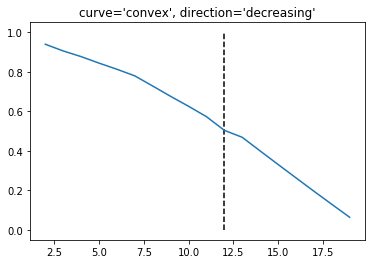

In [476]:
# find the knee points
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')

# plot
plt.plot(K, distortions)
plt.vlines(x=kn.knee, ymin=0, ymax=1, linestyle='--')
plt.title("curve='convex', direction='decreasing'")

print(kn.knee)

In [487]:
true_k = kn.knee
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit_transform(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")
for i in comments:
    Y = vectorizer.transform([i])
    prediction = model.predict(Y)
    print(prediction, i)

Top terms per cluster:
Cluster 0:
 pode
 pode ser
 critério
 ser
 censura
 governo
 decidir
 governo vai
 agora governo
 agora
Cluster 1:
 texto
 projeto
 lei
 impressos
 projeto referência
 impressos outdoor
 outros impressos
 outdoor
 mídias sociais
 mídias
Cluster 2:
 propaganda
 completo
 suspender
 suspender propaganda
 propaganda completo
 correto suspender
 correto
 vi
 suspendida
 ii
Cluster 3:
 autoridades
 medida
 concordo medida
 feminina
 porque feminina
 concordo
 porque
 tempo
 dias tempo
 fim campanha
Cluster 4:
 propagandas
 produtos consumo
 consumo
 produtos
 ampliar além
 ampliar
 além produtos
 além
 poderia ampliar
 poderia
Cluster 5:
 gênero
 deve
 proibir discriminação
 independente gênero
 independente
 discriminação independente
 deve proibir
 proibir
 discriminação
 sofre
Cluster 6:
 vai
 dono
 apelo maior
 malandra vai
 publicitárias dizer
 maior
 têm
 têm apelo
 maior vai
 malandra


Prediction
[3] O problema não me parece ser a conotação erótica ou sexual e